In [1]:
!pip install tensorflow
!pip install tensorflow-federated==0.39

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 912.9/912.9 kB 59.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.2/120.2 kB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.1/578.1 MB 3.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.9/238.9 kB 44.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.3/71.3 MB 24.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 40.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 990.1/990.1 kB 90.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.4/255.4 kB 43.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.7/301.7 kB 55.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39

In [2]:
import collections
import numpy as np
import tensorflow as tf
import tensorflow_federated as tff
import keras
import pandas as pd
import matplotlib.pyplot as plt
import os
from tensorflow.keras.callbacks import TensorBoard

%load_ext tensorboard

np.random.seed(0)

2023-03-16 08:38:51.928085: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-16 08:38:52.110332: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-16 08:38:52.730712: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.6/lib64
2023-03-16 08:38:52.730838: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: can

In [18]:
! pip install kaggle -q

In [19]:
#Download and unzip Kaggle dataset

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download yuweisunut/sidd-segmented-intrusion-detection-dataset
!unzip -q sidd-segmented-intrusion-detection-dataset

sidd-segmented-intrusion-detection-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
replace SIDD/n005/local.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [3]:
NUM_CLIENTS = 15
NUM_EPOCHS = 1
BATCH_SIZE = 32
SHUFFLE_BUFFER = 100
PREFETCH_BUFFER = tf.data.AUTOTUNE

In [4]:
directory = 'SIDD'
client_id = 0
uid = 0
imgs = {}

for client in os.listdir(directory):
  curr_path = f'{directory}/{client}/pcap'

  for subdir in os.listdir(curr_path):
    curr_path = f'{directory}/{client}/pcap/{subdir}/dataset'
    curr_type = subdir[-1:]
    if curr_type == str(1):
   
        for dayscen in os.listdir(curr_path):
          curr_path = f'{directory}/{client}/pcap/{subdir}/dataset/{dayscen}'

          for img in os.listdir(curr_path):
            if dayscen == 'benign':
                imgs[uid] = {'id': uid, 'client_id': client_id, 'label': str(0), 'fn': img, 'path': curr_path + '/' + img}
            elif dayscen == 'malicious':
                imgs[uid] = {'id': uid, 'client_id': client_id, 'label': str(curr_type), 'fn': img, 'path': curr_path + '/' + img}
            uid +=1
  client_id += 1

In [5]:
img_df = pd.DataFrame.from_dict(imgs,orient='index')
img_df['label'] = img_df['label'].astype(int)
#img_df.loc[img_df.index[(img_df['label']==3)],'label'] = 2

In [6]:
def _parse_function(filename, y):
    image_string = tf.io.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string, channels=3)
    X = tf.cast(image_decoded, tf.float32)
    return X, y

In [7]:
file_paths = img_df.path
file_labels = img_df["label"]
client_ids = img_df["client_id"]  
    
X = file_paths
y = file_labels
client_ds = tf.data.Dataset.from_tensor_slices((X, y, client_ids))
test_size = 0.2
train_size = 1 - test_size
ds_length = tf.data.experimental.cardinality(client_ds).numpy()
num_test_samples = int(test_size * ds_length)

train_ds = client_ds.take(train_size * ds_length)
test_ds = client_ds.skip(train_size * ds_length)

2023-03-16 08:39:07.340693: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-16 08:39:07.471563: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-16 08:39:07.471830: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-16 08:39:07.473399: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [8]:
def preprocess(dataset):

  return dataset.repeat(NUM_EPOCHS).shuffle(SHUFFLE_BUFFER, seed=1).batch(
      BATCH_SIZE).prefetch(PREFETCH_BUFFER)

def make_federated_data(client_data, client_ids):
    return [
      preprocess(create_tf_dataset_for_client(client_data, x))
      for x in client_ids
    ]

In [9]:
def create_tf_dataset_for_client(dataset, id_value):
    # Filter elements with the specified id_value
    
    filtered_dataset = dataset.filter(lambda x, y, client_id: tf.equal(client_id, id_value))

    # Remove the id from the filtered dataset
    filtered_dataset = filtered_dataset.map(lambda x, y, client_id: (x, y))
    
    #Load image from path and convert to float32
    def load_image(filename, y):
        image_string = tf.io.read_file(filename)
        image_decoded = tf.image.decode_jpeg(image_string, channels=3)
        X = tf.cast(image_decoded, tf.float32)
        return X, y

    filtered_dataset = filtered_dataset.map(load_image)
    
    print(type(filtered_dataset))


    return filtered_dataset


In [10]:
clients = img_df["client_id"].unique()
#print(type(client_ds))
federated_train_data = make_federated_data(train_ds, clients)
federated_test_data = make_federated_data(test_ds, clients)

print(f'Number of client datasets: {len(federated_train_data)}')
print(f'First dataset: {federated_train_data[0]}')

<class 'tensorflow.python.data.ops.dataset_ops.MapDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.MapDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.MapDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.MapDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.MapDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.MapDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.MapDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.MapDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.MapDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.MapDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.MapDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.MapDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.MapDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.MapDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.MapDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.MapDataset'>
<class 'tensorflow.python.data.ops.datas

In [11]:
def model_fn():
  # We _must_ create a new model here, and _not_ capture it from an external
  # scope. TFF will call this within different graph contexts.
  keras_model = tf.keras.applications.EfficientNetB3(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=2,
    classifier_activation="sigmoid"
    )

  return tff.learning.from_keras_model(
      keras_model,
      input_spec=federated_train_data[0].element_spec,
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [12]:
training_process = tff.learning.algorithms.build_unweighted_fed_avg(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.02),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0))

eval_process = tff.learning.build_federated_evaluation(model_fn)

Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.9/dist-packages/tensorflow_federated/python/learning/keras_utils.py:193: UserWarning: Batch Normalization contains non-trainable variables that won't be updated during the training. Consider using Group Normalization instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/tensorflow/python/autograph/impl/api.py:371: UserWarning: Batch Normalization contains non-trainable variables that won't be updated during the training. Consider using Group Normalization instead.
  return py_builtins.overload_of(f)(*args)


In [13]:
train_state = training_process.initialize()
eval_results_df = pd.DataFrame()
train_results_df = pd.DataFrame()

In [14]:
log_dir = 'logs/fit_federated/'
summary_writer = tf.summary.create_file_writer(log_dir)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

NUM_ROUNDS = 30
with summary_writer.as_default():

    for round_num in range(NUM_ROUNDS):
        
      #Training of actual model  
      result = training_process.next(train_state, federated_train_data)
      train_state = result.state
      train_metrics = result.metrics
        
      accuracy = result.metrics['client_work']['train']['sparse_categorical_accuracy']
      loss = result.metrics['client_work']['train']['loss']  
        
      train_results_df = train_results_df.append({'Round': round_num+1, 'Accuracy': accuracy, 'Loss': loss}, ignore_index=True)  
      print('round {:2d}, metrics={}'.format(round_num, train_metrics))
      
      #Evaluate model
      model_weights = training_process.get_model_weights(train_state)
      test_metrics = eval_process(model_weights, federated_test_data)['eval']
      print(test_metrics)  
      eval_results_df = eval_results_df.append({'Round': round_num+1,
                                      **test_metrics}, ignore_index=True)  


callbacks = [TensorBoard(log_dir=log_dir)]

2023-03-16 08:42:51.287298: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1 of 100
2023-03-16 08:42:51.435622: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-03-16 08:42:59.841268: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2023-03-16 08:43:11.343363: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-03-16 08:43:17.496908: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1 of 100
2023-03-16 08:43:17.557900: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-03-16 08:43:32.687688: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1 of 100
2023-03-16 08:43:32.695462: I tensorflow/core/kernels/data/shuffle_d

round  0, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.94525677), ('loss', 0.11650992), ('num_examples', 1108466), ('num_batches', 34642)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_count', ())])), ('finalizer', ())])


2023-03-16 09:28:22.681243: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1 of 100
2023-03-16 09:28:22.681311: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2 of 100
2023-03-16 09:28:22.764904: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


OrderedDict([('sparse_categorical_accuracy', 0.9752957), ('loss', 0.11681803), ('num_examples', 277118), ('num_batches', 8661)])


/tmp/ipykernel_32/1569588565.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eval_results_df = eval_results_df.append({'Round': round_num+1,
2023-03-16 09:31:11.477877: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1 of 100
2023-03-16 09:31:11.535371: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-03-16 09:31:17.244312: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1 of 100
2023-03-16 09:31:17.268744: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2 of 100
2023-03-16 09:31:17.305165: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-03-16 09:31:42.751894: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buff

KeyboardInterrupt: 

In [16]:
%tensorboard --logdir logs/fit/

In [ ]:
print(eval_results_df.head(5))
print(train_results_df.head(5))

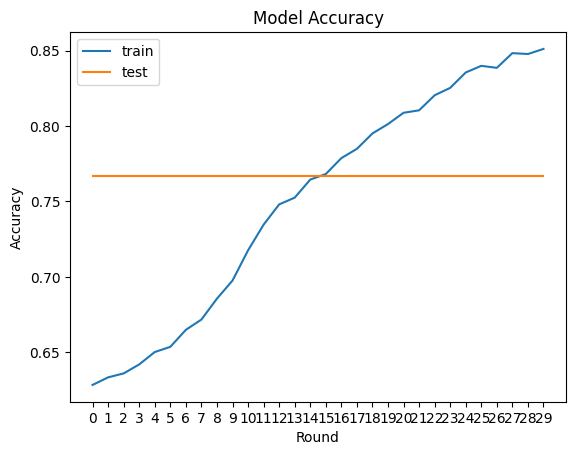

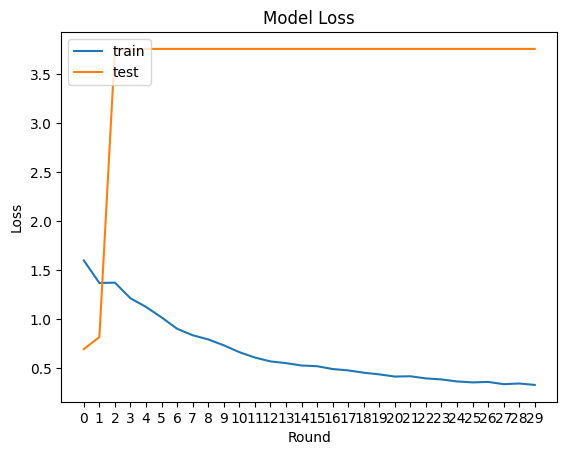

In [17]:
eval_results_df = eval_results_df.rename(columns={'sparse_categorical_accuracy': 'Accuracy', 'loss': 'Loss'})

#Plot accuracy of model
plt.plot(train_results_df['Accuracy'])
plt.plot(eval_results_df['Accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Round')
plt.legend(['train', 'test'], loc='upper left')
plt.xticks(range(len(train_results_df['Accuracy'])))
plt.show()

#Plot loss of model
plt.plot(train_results_df['Loss'])
plt.plot(eval_results_df['Loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Round')
plt.legend(['train', 'test'], loc='upper left')
plt.xticks(range(len(train_results_df['Loss'])))
plt.show()

In [19]:
!ls {logdir}
%tensorboard --logdir {logdir}

events.out.tfevents.1676387843.nuzdv1oqq8.32.0.v2


UsageError: Line magic function `%tensorboard` not found.
